In [1]:
import numpy as np
import torch
import os
import json
import pickle
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, \
    TrainingArguments, Trainer

In [2]:
ROOT = os.path.dirname(os.path.realpath("__file__"))
DATASET = os.path.join(ROOT, "..", "..", "..", "Datasets", "FUNSD", "dataset")
TRAINSET = os.path.join(DATASET, "training_data")
TESTSET = os.path.join(DATASET, "testing_data")

EPOCHS = 10

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

In [3]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

class FUNSDDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded = encoded_data
        
    def __getitem__(self, idx):
        resdict = {k: v[idx] for k, v in self.encoded.items()}
        return resdict
    
    def __len__(self):
        return len(self.encoded['labels'])

def assemble_dataset(dset_path):
    anno_path = os.path.join(dset_path, "annotations")
    imgs_path = os.path.join(dset_path, "images")
    
    files = os.listdir(imgs_path)
    files = [f.split('.')[0] for f in files]
    
    id2label = {}
    label2id = {}

    dataset = {
        'image' : [],
        'input_ids' : [],
        'attention_mask' : [],
        'token_type_ids' : [],
        'bbox' : [],
        'labels' : [],
    }

    
    for f in files:
        image = Image.open(os.path.join(imgs_path, f"{f}.png")).convert("RGB")
        with open(os.path.join(anno_path, f"{f}.json"), "r") as jsonfile:
            data = json.load(jsonfile)
            
        labels = list(set([form['label'] for form in data['form']]))
        labels.sort()
        
        id2label.update(dict(enumerate(labels)))
        label2id.update({v: k for k, v in id2label.items()})
        
        words = []
        bboxes = []
        labels = []
        
        for ent in data['form']:
            labels.extend([label2id[ent['label']]] * len(ent['words']))
            for w in ent['words']:
                words.append(w['text'])
                bboxes.append(normalize_bbox(w['box'], image.width, image.height))
                
        encoded_input = processor(image,
                                  words,
                                  boxes=bboxes,
                                  word_labels=labels,
                                  padding="max_length",
                                  truncation=True)
        
        encoded_input['image'] = encoded_input['image'][0]
        for key in dataset:
            dataset[key].append(encoded_input[key])

            
    return FUNSDDataset(dataset), id2label, label2id

In [4]:
train_dataset, id2label, label2id = assemble_dataset(TRAINSET)
test_dataset, _, _ = assemble_dataset(TESTSET)

In [5]:
len(train_dataset)

149

In [6]:
id2label

{0: 'answer', 1: 'header', 2: 'other', 3: 'question'}

In [7]:
label2id

{'answer': 0, 'header': 1, 'other': 2, 'question': 3}

In [9]:
metrics_log = []

def flatten_pred_labels(pred, labels):
    flat_preds = []
    flat_labels = []
    
    for pred_doc, label_doc in zip(pred, labels):
        for pred, label in zip(pred_doc, label_doc):
            if label != -100:
                flat_labels.append(label)
                flat_preds.append(np.argmax(pred))
                
    return flat_preds, flat_labels

def compute_metrics(p):
    pred, labels = p
    pred, labels = flatten_pred_labels(pred, labels)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_micro = recall_score(y_true=labels, y_pred=pred, average='micro')
    recall_macro = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_micro = precision_score(y_true=labels, y_pred=pred, average='micro')
    precision_macro = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_micro = f1_score(y_true=labels, y_pred=pred, average='micro')
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')

    metrics = {
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "precision_macro": precision_macro,
        "recall_micro": recall_micro,
        "recall_macro": recall_macro,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro
    }
    global metrics_log
    metrics_log.append(metrics)
    return metrics

In [10]:
train_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    save_strategy="no",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50
)

In [11]:
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", num_labels=4)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.12.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv1.norm.num_batches_trac

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [13]:
trainer.train()

***** Running training *****
  Num examples = 149
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 750


Step,Training Loss,Validation Loss,Accuracy,Precision Micro,Precision Macro,Recall Micro,Recall Macro,F1 Micro,F1 Macro
50,1.352200,1.297277,0.428905,0.428905,0.427640,0.428905,0.290013,0.428905,0.217838
100,1.206700,1.133123,0.564908,0.564908,0.549446,0.564908,0.410825,0.564908,0.339669
150,0.982100,0.846833,0.778660,0.778660,0.579490,0.778660,0.608291,0.778660,0.593064
200,0.788900,0.766937,0.773990,0.773990,0.782028,0.773990,0.686075,0.773990,0.716184
250,0.734000,0.691811,0.816484,0.816484,0.774975,0.816484,0.763004,0.816484,0.767551
300,0.664600,0.648714,0.824072,0.824072,0.792853,0.824072,0.780865,0.824072,0.785530
350,0.578600,0.755757,0.754028,0.754028,0.741835,0.754028,0.722275,0.754028,0.721652
400,0.534400,0.714139,0.770488,0.770488,0.730060,0.770488,0.743477,0.770488,0.727528
450,0.549500,0.674678,0.786248,0.786248,0.718031,0.786248,0.752188,0.786248,0.730034
500,0.474600,0.635257,0.794420,0.794420,0.713656,0.794420,0.763519,0.794420,0.729277


***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/home/vspecky/Programming/Pibit/deep_learning/policy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/home/vspecky/Programming/Pibit/deep_learning/policy/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/home/vspecky/Programming/Pibit/deep_learning/policy/.venv/lib/python3.8/site-packages/sklearn/metrics/_

TrainOutput(global_step=750, training_loss=0.6397737922668457, metrics={'train_runtime': 373.1187, 'train_samples_per_second': 3.993, 'train_steps_per_second': 2.01, 'total_flos': 804343095582720.0, 'train_loss': 0.6397737922668457, 'epoch': 10.0})

In [ ]:
trainer.save_model("./layoutlm_10ep_2")

In [15]:
metrics_log

[{'accuracy': 0.4289049731496615,
  'precision_micro': 0.4289049731496615,
  'precision_macro': 0.4276397317062327,
  'recall_micro': 0.4289049731496615,
  'recall_macro': 0.29001319822222765,
  'f1_micro': 0.4289049731496615,
  'f1_macro': 0.21783785643442816},
 {'accuracy': 0.5649077749241186,
  'precision_micro': 0.5649077749241186,
  'precision_macro': 0.5494455970316386,
  'recall_micro': 0.5649077749241186,
  'recall_macro': 0.4108252692450669,
  'f1_micro': 0.5649077749241186,
  'f1_macro': 0.3396692608184931},
 {'accuracy': 0.7786598178846603,
  'precision_micro': 0.7786598178846603,
  'precision_macro': 0.5794904686753749,
  'recall_micro': 0.7786598178846603,
  'recall_macro': 0.6082910632237857,
  'f1_micro': 0.7786598178846603,
  'f1_macro': 0.5930641330247307},
 {'accuracy': 0.7739901937893999,
  'precision_micro': 0.7739901937893999,
  'precision_macro': 0.7820277735677826,
  'recall_micro': 0.7739901937893999,
  'recall_macro': 0.6860745067094375,
  'f1_micro': 0.7739901

In [16]:
import json

In [17]:
with open("metrics.json", "w") as jsonfile:
    json.dump(metrics_log, jsonfile, indent=4)

In [19]:
import matplotlib.pyplot as plt

In [22]:
X = [50 * e for e in range(1, 16)]
X

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]

In [23]:
len(X)

15

In [24]:
len(metrics_log)

15

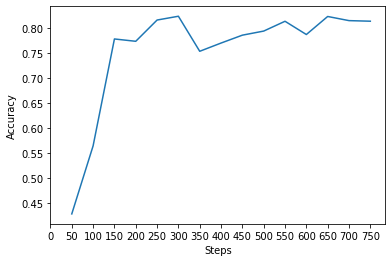

In [50]:
acc = [m["accuracy"] for m in metrics_log]

plt.plot(X, acc, label="Accuracy")
plt.xticks(range(0, 751, 50))
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.savefig("graphs/accuracy.png")
plt.savefig("graphs/accuracy_nt.png", facecolor='white', transparent=False)
plt.savefig(f"graphs/accuracy.svg", facecolor='white', transparent=False, format="svg")

plt.show()

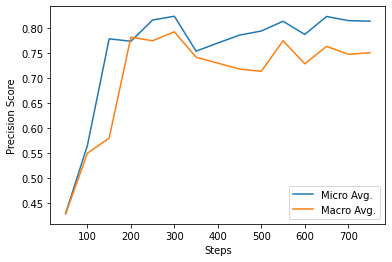

In [37]:
prec_micro = [m["precision_micro"] for m in metrics_log]
prec_macro = [m["precision_macro"] for m in metrics_log]

plt.plot(X, prec_micro, label="Micro Avg.")
plt.plot(X, prec_macro, label="Macro Avg.")
plt.xlabel("Steps")
plt.ylabel("Precision Score")
plt.legend()
plt.savefig("precision.png")
plt.savefig("precision_nt.png", facecolor='white', transparent=False)
plt.show()

In [49]:
def plot_n_save(key):
    cap = key[0].upper() + key[1:]
    
    micro = [m[f"{key}_micro"] for m in metrics_log]
    macro = [m[f"{key}_macro"] for m in metrics_log]
    
    plt.plot(X, micro, label="Micro Avg.")
    plt.plot(X, macro, label="Macro Avg.")
    plt.xlabel("Steps")
    plt.ylabel(f"{cap} Score")
    plt.legend()
    plt.savefig(f"graphs/{key}.png")
    plt.savefig(f"graphs/{key}_nt.png", facecolor='white', transparent=False)
    plt.savefig(f"graphs/{key}.svg", facecolor='white', transparent=False, format="svg")
    plt.show()

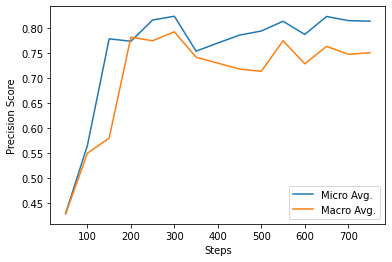

In [46]:
plot_n_save("precision")

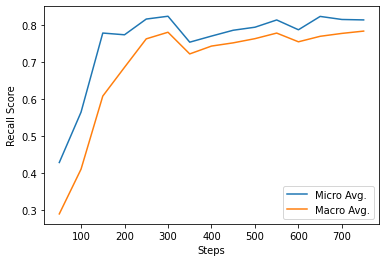

In [47]:
plot_n_save("recall")

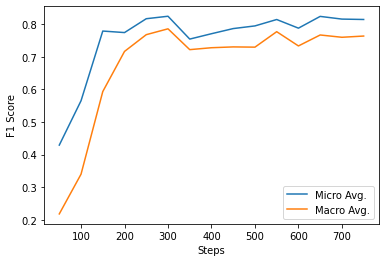

In [48]:
plot_n_save("f1")

In [55]:
def extract_loss(loss):
    with open(loss, "r") as lossfile:
        string = lossfile.read()
        
    strvals = string.split('\n')
    if strvals[-1] == '':
        strvals = strvals[:-1]
    print(strvals)
    floatvals = list(map(float, strvals))
    return floatvals

In [56]:
train_loss = extract_loss("training_loss")
val_loss = extract_loss("validation_loss")

['1.352200', '1.206700', '0.982100', '0.788900', '0.734000', '0.664600', '0.578600', '0.534400', '0.549500', '0.474600', '0.417700', '0.400500', '0.335300', '0.289800', '0.287600']
['1.297277', '1.133123', '0.846833', '0.766937', '0.691811', '0.648714', '0.755757', '0.714139', '0.674678', '0.635257', '0.621757', '0.641914', '0.591628', '0.604202', '0.605374']


In [57]:
train_loss

[1.3522,
 1.2067,
 0.9821,
 0.7889,
 0.734,
 0.6646,
 0.5786,
 0.5344,
 0.5495,
 0.4746,
 0.4177,
 0.4005,
 0.3353,
 0.2898,
 0.2876]

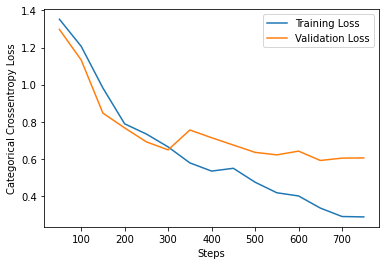

In [60]:
plt.plot(X, train_loss, label="Training Loss")
plt.plot(X, val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel(f"Categorical Crossentropy Loss")
plt.legend()
plt.savefig(f"metrics/loss.png")
plt.savefig(f"metrics/loss_nt.png", facecolor='white', transparent=False)
plt.savefig(f"metrics/loss.svg", facecolor='white', transparent=False, format="svg")
plt.show()